# Sprint 深層学習スクラッチ 畳み込みニューラルネットワーク2

## 1.このSprintについて

### Sprintの目的
- スクラッチを通してCNNの基礎を理解する

### どのように学ぶか
- スクラッチで2次元用畳み込みニューラルネットワークを実装した後、学習と検証を行なっていきます。



## 2.2次元の畳み込みニューラルネットワークスクラッチ

2次元に対応した畳み込みニューラルネットワーク（CNN）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


プーリング層なども作成することで、CNNの基本形を完成させます。クラスの名前はScratch2dCNNClassifierとしてください。



### データセットの用意
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。


今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。


(n_samples, n_channels, height, width)のNCHWまたは(n_samples, height, width, n_channels)のNHWCどちらかの形にしてください。

In [1]:
# ライブラリインポート
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics 
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from abc import *
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# データ読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# shape
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [3]:
# テスト実行用
train_ln = 5000
test_ln = 5000

X_train = X_train[:train_ln, :, :]
y_train = y_train[:train_ln]
X_test = X_test[:test_ln, :, :]
y_test = y_test[:test_ln]

# shape
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5000, 28, 28), (5000,), (5000, 28, 28), (5000,))

## 【まとめ】最終コード

### ★ScratchDeepNeuralNetrowkClassifier

In [4]:
class ScratchDeepNeuralNetrowkClassifier:
    """
    シンプルな三層ニューラルネットワーク分類器
 
    Parameters
    ----------
    sigma : float
      シグマの値
    lr : float
      学習率
    epoch : int
      エポック数
    verbose : bool
      学習過程表示・非表示
    interval : int
      学習過程の表示間隔
 
    Attributes
    ----------
    """
    def __init__(self, verbose=False, interval=1):
        self.verbose = verbose
        self.interval = interval

    
    def fit(self, X, y, X_val=None, y_val=None, sigma=0.01, lr=0.01, epoch=3, optimizer='SGD'):
        """
        ニューラルネットワーク分類器を学習する。
 
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # 引数をインスタンス変数へ
        self.sigma = sigma
        self.lr = lr
        self.epoch = epoch

        # 検証データの有無
        self.is_val = np.all(X_val != None) and np.all(y_val != None)

        # ミニバッチ
        batch_size = 20
        seed = 47

        # 形状・各層のノード数
        self.n_samples = X.shape[0]
        self.n_features = X.shape[-1]
        self.inputLayer_nodes = self.n_features
        self.fc1_nodes = 400
        self.fc2_nodes = 200
        self.out_nodes = 10
        self.optimizer = optimizer

        # CNN用
        self.n_channels = 1
        self.kernel_size = (3,3)
        self.n_filters = 5
        self.n_strides = (1,1)
        self.CNN_input_shape = (self.n_channels, X.shape[-2], X.shape[-1])
        self.CNN_output_shape = None


        # 誤差格納用
        self.loss = []
        self.val_loss = []

        # yラベルデータをone-hotへ変換
        y = self._y_one_hot(y)
        if self.is_val:
            y_val = self._y_one_hot(y_val)

        # 最適化手法
        if self.optimizer == 'SGD':
            optimizer = SGD(self.lr)
        elif self.optimizer == 'AdaGrad':
            optimizer = AdaGrad(self.lr)


        # 各層・活性化関数のインスタンス生成
        self.CNN = Conv2d(input_shape = self.CNN_input_shape, 
                          initializer = HeInitializer(self.sigma, self.kernel_size[0], self.kernel_size[1]),
                          filters = self.n_filters,
                          kernel_size = self.kernel_size,
                          strides = self.n_strides,
                          padding = 'valid',
                          optimizer = optimizer)
        self.activationCNN = ReLU()

        self.POO = MaxPooling(batch_size, (3,3), self.CNN)
        self.flatten = Flatten(self.POO)
        self.POO_output_features = self.flatten.output_flat_shape[-1]

        self.FC1 = FC(HeInitializer(self.sigma, self.POO_output_features, self.fc1_nodes), optimizer)
        self.activation1 = ReLU()
        self.FC2 = FC(HeInitializer(self.sigma, self.fc1_nodes, self.fc2_nodes), optimizer)
        self.activation2 = ReLU()
        self.OUT = FC(HeInitializer(self.sigma, self.fc2_nodes, self.out_nodes), optimizer)
        self.activationOUT = Softmax()

        # ミニバッチ化
        getMiniBatch = GetMiniBatch(X, y, batch_size=batch_size, seed=seed)
        if self.is_val:
            val_batch_size = int(X_val.shape[0] / (self.n_samples/batch_size))
            getValMiniBatch = GetMiniBatch(X_val, y_val, batch_size=val_batch_size, seed=seed)
        else:
            getValMiniBatch = np.zeros([self.n_samples, 2])

        for epoch in range(self.epoch):
            for train, val in zip(getMiniBatch, getValMiniBatch):
                mini_X, mini_y = train
                mini_X_val, mini_y_val = val

                # フォワードプロパゲーション
                Z3 = self._forward_propagation(mini_X)
                # バックプロパゲーション
                self._back_propagation(mini_X, mini_y, Z3)

                if self.is_val:
                    # フォワードプロパゲーション
                    val_Z = self._forward_propagation(mini_X_val)
                    # 損失関数計算
                    self.activationOUT.cross_entropy_loss(val_Z, mini_y_val, self.is_val)

            # バッチ毎の損失の平均取得
            self._get_loss()

            # 学習過程表示
            if self.verbose and epoch % self.interval == 0:
                self._print_loss(epoch)


    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
 
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
 
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        # 推定
        pred = np.argmax(self._forward_propagation(X), axis=1)
        return pred


    def _y_one_hot(self, y):
        """
        yラベルをone-hot化する処理
        """
        y_onehot = np.zeros([len(y), self.out_nodes])
        for i, yk in enumerate(y):
            y_onehot[i,yk] = 1
        return y_onehot


    def _forward_propagation(self, X):
        """
        フォワードプロパゲーション
        """
        X = self.activationCNN.forward(self.CNN.forward(X))
        X = self.POO.forward(X)
        X = self.flatten.forward(X)
        X = self.activation1.forward(self.FC1.forward(X))
        X = self.activation2.forward(self.FC2.forward(X))
        X = self.activationOUT.forward(self.OUT.forward(X))
        return X


    def _back_propagation(self, X, y, Z):
        """
        バックプロパゲーション
        """
        dZ = self.OUT.backward(self.activationOUT.backward(Z, y))
        dZ = self.FC2.backward(self.activation2.backward(dZ))
        dZ = self.FC1.backward(self.activation1.backward(dZ))
        dZ = self.POO.backward(self.flatten.backward(dZ))
        _ = self.CNN.backward(self.activationCNN.backward(dZ))


    def _get_loss(self):
        """
        損失取得処理
        """
        self.loss.append(np.mean(self.activationOUT.loss))
        self.activationOUT.loss = []
        if self.is_val:
            self.val_loss.append(np.mean(self.activationOUT.val_loss))
            self.activationOUT.val_loss = []


    def _print_loss(self, epoch):
        """
        学習過程表示用
        """
        print('[INFO] epoch : {} / {}'.format(epoch+1, self.epoch))
        print('       Loss(train): {}'.format(self.loss[-1]))
        print('       Loss(test) : {}'.format(self.val_loss[-1]))

### ★Conv2d

In [5]:
class Conv2d:
    def __init__(self, input_shape, filters=1, kernel_size=(3,3), strides=(1,1), padding='valid', initializer=None, optimizer=None):
        # 引数チェック
        assert len(input_shape) == 3          # ex) input_shape = [1000, 3, 28, 28]
        assert isinstance(filters, int)       # ex) filters = 1
        assert len(kernel_size) == 2          # ex) kernel_size = (3, 3) = (h, w)
        assert len(strides) == 2              # ex) strides = (2, 2)
        assert padding in ['valid', 'same']   # ex) padding = 'same'

        # 引数をインスタンス変数として設定
        self.input_shape = input_shape
        self.n_features = np.array([self.input_shape[-2], self.input_shape[-1]]).astype(int)
        self.n_channels = np.int(self.input_shape[-3])
        self.n_samples = None
        self.batch_size = self.n_samples
        self.n_filters = int(filters)
        self.kernel_size = np.array(kernel_size).astype(int)
        self.strides = np.array(strides).astype(int)
        self.padding = padding
        self.n_padding = np.array([0,0])
        self.initializer = initializer
        self.optimizer = optimizer
        self.W = np.zeros([self.n_filters, self.n_channels, self.kernel_size[0], self.kernel_size[1]])
        self.B = np.zeros([1, self.n_filters])
    
        # パディング値の設定
        if self.padding == 'same':
            self.n_padding = self.n_features - ((self.n_features - self.kernel_size) / self.strides + 1)
            assert self.n_padding % 2 == 0, '[ERROR] padding or strides number is incorrect.'
            self.n_padding = (self.n_padding / 2).astype(int)      

        # Utilクラスの初期化
        self.util = Util(self.n_channels, self.n_features, self.kernel_size, self.n_padding, self.strides)

        # 畳み込み後の形状 (画像縦, 画像横)
        self.output_shape = self.util.get_output_shape()

        # フィルター(w,b)の初期化
        for f in range(self.n_filters):
            for c in range(self.n_channels):
                self.W[f, c, :, :] += self.initializer.W()

        self.B += self.initializer.B(self.n_filters).reshape(1,-1)

        # AdaGrad用変数
        self.H_W = np.zeros([self.n_filters, self.n_channels, self.kernel_size[0], self.kernel_size[1]])
        self.H_B = np.zeros(self.B.shape[-1])



    def forward(self, X):
        '''順伝播処理'''
        # 引数チェック
        assert X.ndim >= 3
        self.X = X.copy()
        self.n_samples = self.X.shape[0]
        self.batch_size = self.n_samples

        # Xを4次元に調整 (データ数, チャネル数, 画像縦, 画像横)
        self.X = self.util.xdim_ctl(self.X)

        # パディングの0埋め処理
        self.X = self.util.padding_proc(self.X)

        # 出力値の計算
        self.cols = self.util.im2col(self.X)
        self.colW = self.W.reshape(self.n_filters, -1).T
        A = self.cols @ self.colW + self.B
        A = A.reshape(self.n_samples, self.output_shape[0], self.output_shape[1], -1).transpose(0,3,1,2)
        return A


    def backward(self, dA):
        '''逆伝播処理'''
        dA = dA.transpose(0,2,3,1).reshape(-1, self.n_filters)
        self.dW = self.cols.T @ dA
        self.dB = np.sum(dA, axis=0)

        dcols = dA @ self.colW.T
        dX = self.util.col2im(dcols)

        # 更新
        self.dW = self.dW.transpose(1,0).reshape(self.n_filters, self.n_channels, self.kernel_size[0], self.kernel_size[1])
        self.optimizer.update(self)
        return dX


### ★Util

In [6]:
class Util:
    def __init__(self, n_channels, n_features, kernel_size, n_padding, strides):
        self.n_samples = None
        self.input_shape = None
        self.n_channels = n_channels
        self.n_features = n_features
        self.kernel_size = kernel_size
        self.n_padding = n_padding
        self.strides = strides
        self.output_shape = self.get_output_shape()


    def xdim_ctl(self, X):
        '''Xを4次元に調整 (データ数, チャネル数, 画像縦, 画像横)'''
        if X.ndim == 2:
            X = X[np.newaxis, np.newaxis, :, :]
        elif X.ndim == 3:
            if self.n_channels == 1 and X.shape[0] > 1:
                X = X[:, np.newaxis, :, :]
            else:
                X = X[np.newaxis, :, :, :]
        elif X.ndim == 4:
            pass
        else:
            raise ValueError("X is unexpected value.")
        return X


    def get_output_shape(self):
        '''畳み込み後の形状'''
        output_img_shape = ((self.n_features + 2*self.n_padding - self.kernel_size) // self.strides + 1).astype(int)
        return output_img_shape


    def padding_proc(self, X):
        '''Xデータをパディングで0埋め'''
        assert X.ndim == 4
        X = np.pad(X, [0, 0])
        if np.sum(self.n_padding) != 0:
            X = np.pad(X, [(0,0), (0,0), (self.n_padding[0],self.n_padding[0]), (self.n_padding[1], self.n_padding[1])], 'constant')
        return X


    def im2col(self, data):
        '''多次元データを2次元行列へ変換'''
        assert data.ndim == 4
        N, C, H, W = data.shape
        self.input_shape = data.shape
        cols = np.zeros((N, C, self.kernel_size[0], self.kernel_size[1], self.output_shape[0], self.output_shape[1]))
        for h in range(self.kernel_size[0]):
            h_max = h + self.strides[0]*self.output_shape[0]
            for w in range(self.kernel_size[1]):
                w_max = w + self.strides[1]*self.output_shape[1]
                cols[:, :, h, w, :, :] = data[:, :, h:h_max:self.strides[0], w:w_max:self.strides[1]]
        cols = cols.transpose(0,4,5,1,2,3).reshape(N*self.output_shape[0]*self.output_shape[1], -1)
        return cols


    def col2im(self, data):
        '''2次元行列を多次元データへ変換'''
        N, C, H, W = self.input_shape
        data = data.reshape(N, self.output_shape[0], self.output_shape[1], C, self.kernel_size[0], self.kernel_size[1]).transpose(0, 3, 4, 5, 1, 2)
        img = np.zeros((N, C, H + 2*self.n_padding[0] + self.strides[0] - 1, W + 2*self.n_padding[1] + self.strides[1] - 1))
        for h in range(self.kernel_size[0]):
            h_max = h + self.strides[0]*self.output_shape[0]
            for w in range(self.kernel_size[1]):
                w_max = w + self.strides[1]*self.output_shape[1]
                img[:, :, h:h_max:self.strides[0], w:w_max:self.strides[1]] += data[:, :, h, w, :, :]
        img = img[:, :, self.n_padding[0]:H + self.n_padding[0], self.n_padding[1]:W + self.n_padding[1]]
        return img

### ★Pooling

In [7]:
class Pooling(metaclass=ABCMeta):
    def __init__(self, n_samples: int, pool: tuple, cnn):
        assert len(pool) == 2
        self.n_features = cnn.output_shape
        self.n_channels = cnn.n_channels
        self.n_samples = n_samples
        self.n_filters = cnn.n_filters
        self.pool_h = int(pool[0])
        self.pool_w = int(pool[1])
        self.pool = np.array(pool).astype(int)
        self.strides = np.array([1, 1]).astype(int)
        self.n_padding = np.array([0, 0]).astype(int)
        self.util = Util(self.n_channels, self.n_features, pool, self.n_padding, self.strides)
        self.output_shape = self.util.get_output_shape()
        
        self.x = None
        self.args = None


    @abstractmethod
    def forward(self):
        """
        順伝播処理
        """
        pass

    @abstractmethod
    def backward(self):
        """
        逆伝播処理
        """
        pass
    

    # def forward(self, x):
    #     col = self.util.im2col(x)
    #     col = col.reshape(-1, self.pool_h*self.pool_w)
    #     out, args = self.p_forward(x, col)
    #     self.x = x
    #     self.args = args
    #     return out


    # def backward(self, dA):
    #     dA = dA.transpose(0, 2, 3, 1)
        
    #     pool_size = self.pool_h * self.pool_w
    #     dmax = np.zeros((dA.size, pool_size))
    #     dmax[np.arange(self.args.size), self.args.flatten()] = dA.flatten()
    #     dmax = dmax.reshape(dA.shape + (pool_size,)) 
        
    #     dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
    #     dx = self.util.col2im(dcol)
    #     return dx


class MaxPooling(Pooling):
    def forward(self, x):
        col = self.util.im2col(x)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.strides[0])
        out_w = int(1 + (W - self.pool_w) / self.strides[1])
        args = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        out /= np.max(out)+1e-7

        self.x = x
        self.args = args
        return out

    def backward(self, dA):
        dA = dA.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dA.size, pool_size))
        dmax[np.arange(self.args.size), self.args.flatten()] = dA.flatten()
        dmax = dmax.reshape(dA.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = self.util.col2im(dcol)
        return dx


### ★Flatten

In [8]:
class Flatten:
    def __init__(self, FC):
        self.n_samples = FC.n_samples
        self.output_shape = [self.n_samples, FC.n_filters, FC.output_shape[0], FC.output_shape[1]]
        self.output_flat_shape = (FC.n_samples, FC.n_filters * FC.output_shape[0] * FC.output_shape[1])

    def __call__(self):
        return self.output_flat_shape

    def forward(self, data):
        self.n_samples = data.shape[0]
        self.output_shape[0] = self.n_samples
        flatten_data = data.reshape(self.n_samples, -1)
        return flatten_data

    def backward(self, data):
        return data.reshape(self.output_shape)

### ★ FC

In [9]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, initializer, optimizer):
        self.optimizer = optimizer
        # w,bの初期化
        self.W = initializer.W()
        self.B = initializer.B()
        self.H_W = np.zeros([self.W.shape[0], self.W.shape[1]])
        self.H_B = np.zeros(self.B.shape[1])

        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.batch_size = X.shape[0]
        self.X = X
        A = X @ self.W + self.B
        return A


    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dW = self.X.T @ dA
        self.dB = np.sum(dA, axis=0)
        dZ = dA @ self.W.T
        # 更新
        self.optimizer.update(self)
        return dZ

### ★ Initializer

In [10]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma, n_nodes1, n_nodes2):
        self.sigma = sigma
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.mean = 0
        self.s = 1

    def W(self):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
 
        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.normal(loc=self.mean, scale=self.s, size=(self.n_nodes1, self.n_nodes2))
        return W


    def B(self, num=None):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
 
        Returns
        ----------
        B :
        """
        if num == None:
            # B = self.sigma * np.random.normal(loc=self.mean, scale=self.s, size=(1, self.n_nodes2))
            B = np.zeros([1, self.n_nodes2])
        else:
            B = np.zeros([1, num])
        return B


class XavierInitializer(SimpleInitializer):
    def __init__(self, sigma, n_nodes1, n_nodes2):
        super().__init__(sigma, n_nodes1, n_nodes2)
        self.sigma = 1
        self.s = 1 / np.sqrt(n_nodes1)
        pass


class HeInitializer(SimpleInitializer):
    def __init__(self, sigma, n_nodes1, n_nodes2):
        super().__init__(sigma, n_nodes1, n_nodes2)
        self.sigma = 1
        self.s = np.sqrt(2 / self.n_nodes1)
    pass



### ★ Optimizer

In [11]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -= self.lr * layer.dW / layer.batch_size
        layer.B -= self.lr * layer.dB / layer.batch_size

        return layer.W, layer.B

class AdaGrad():
    def __init__(self, lr):
        self.lr = lr
        

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.H_W += layer.dW * layer.dW / layer.batch_size
        layer.W -= self.lr * layer.dW / (np.sqrt(layer.H_W) + 1e-7) / layer.batch_size

        layer.H_B += layer.dB * layer.dB / layer.batch_size
        layer.B -= self.lr * layer.dB / (np.sqrt(layer.H_B) + 1e-7) / layer.batch_size

        return layer.W, layer.B
    

### ★ Activation

In [12]:
class Softmax:
    def __init__(self):
        self.loss = []
        self.val_loss = []
        pass

    def forward(self, A):
        A -= np.max(A)   # オーバーフロー対策
        self.Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        return self.Z

    def backward(self, Z, Y):
        dA = Z - Y
        self.cross_entropy_loss(Z, Y)
        return dA
    
    def cross_entropy_loss(self, Z, Y, val=False):
        batch_size = Z.shape[0]
        delta = 1e-7
        loss = - np.sum(Y * np.log(Z + delta)) / batch_size
        if not val:
            self.loss.append(loss)
        else:
            self.val_loss.append(loss)
        return loss


class Tanh:
    def __init__(self):
        pass

    def forward(self, A):
        self.Z = np.tanh(A)
        return self.Z

    def backward(self, dZ):
        dA = dZ * (1 - dZ**2)
        return dA


class ReLU:
    def __init__(self):
        self.mask = None
        pass

    def forward(self, A):
        self.mask = (A <= 0)
        self.Z = A.copy()
        self.Z[self.mask] = 0
        return self.Z

    def backward(self, dZ):
        dZ[self.mask] = 0
        dA = dZ
        return dA

### ※GetMiniBatch

In [13]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
 
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

## 【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$

a
i
,
j
,
m
 : 出力される配列のi行j列、mチャンネルの値


i
 : 配列の行方向のインデックス


j
 : 配列の列方向のインデックス


m
 : 出力チャンネルのインデックス


K
 : 入力チャンネル数


F
h
,
F
w
 : 高さ方向（h）と幅方向（w）のフィルタのサイズ


x
(
i
+
s
)
,
(
j
+
t
)
,
k
 : 入力の配列の(i+s)行(j+t)列、kチャンネルの値


w
s
,
t
,
k
,
m
 : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み


b
m
 : mチャンネルへの出力のバイアス項


全てスカラーです。


次に更新式です。1次元畳み込み層や全結合層と同じ形です。


$$
w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}} \\
b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}
$$


α
 : 学習率


∂
L
∂
w
s
,
t
,
k
,
m
 : 
w
s
,
t
,
k
,
m
 に関する損失 
L
 の勾配


∂
L
∂
b
m
 : 
b
m
 に関する損失 
L
 の勾配


勾配 
∂
L
∂
w
s
,
t
,
k
,
m
 や 
∂
L
∂
b
m
 を求めるためのバックプロパゲーションの数式が以下である。


 $$
 \frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}\\
\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
 $$

 ∂
L
∂
a
i
  : 勾配の配列のi行j列、mチャンネルの値


N
o
u
t
,
h
,
N
o
u
t
,
w
 : 高さ方向（h）と幅方向（w）の出力のサイズ


前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$$


∂
L
∂
x
i
,
j
,
k
 : 前の層に流す誤差の配列のi列j行、kチャンネルの値


M
 : 出力チャンネル数


ただし、 
i
−
s
<
0
 または 
i
−
s
>
N
o
u
t
,
h
−
1
 または 
j
−
t
<
0
 または 
j
−
t
>
N
o
u
t
,
w
−
1
 のとき 
∂
L
∂
a
(
i
−
s
)
,
(
j
−
t
)
,
m
=
0
 です。



### 【解答】

該当箇所
```
class Conv2d:
 
    def forward(self, X):
        '''順伝播処理'''
        # 引数チェック
        assert X.ndim >= 3
        self.X = X.copy()

        # Xを4次元に調整 (データ数, チャネル数, 画像縦, 画像横)
        self.X = self.util.xdim_ctl(self.X)

        # パディングの0埋め処理
        self.X = self.util.padding_proc(self.X)

        # 出力値の計算
        self.cols = self.util.im2col(self.X)
        self.colW = self.W.reshape(self.n_filters, -1).T
        A = self.cols @ self.colW + self.B
        A = A.reshape(self.n_samples, self.output_shape[0], self.output_shape[1], -1).transpose(0,3,1,2)
        return A


    def backward(self, dA):
        '''逆伝播処理'''
        dA = dA.transpose(0,2,3,1).reshape(-1, self.n_filters)
        self.dW = self.cols.T @ dA
        self.dB = np.sum(dA, axis=0)

        dcols = dA @ self.colW.T
        dX = self.util.col2im(dcols)

        # 更新
        self.dW = self.dW.transpose(1,0).reshape(self.n_filters, self.n_channels, self.kernel_size[0], self.kernel_size[1])
        self.optimizer.update(self)
        return dX

```

以下は、プーリング層がない状態でのCNN

In [14]:
class ScratchDeepNeuralNetrowkClassifierNotPooling(ScratchDeepNeuralNetrowkClassifier):
    def fit(self, X, y, X_val=None, y_val=None, sigma=0.01, lr=0.01, epoch=3, optimizer='SGD'):
        # 引数をインスタンス変数へ
        self.sigma = sigma
        self.lr = lr
        self.epoch = epoch

        # 検証データの有無
        self.is_val = np.all(X_val != None) and np.all(y_val != None)

        # ミニバッチ
        batch_size = 20
        seed = 47

        # 形状・各層のノード数
        self.n_samples = X.shape[0]
        self.n_features = X.shape[-1]
        self.inputLayer_nodes = self.n_features
        self.fc1_nodes = 400
        self.fc2_nodes = 200
        self.out_nodes = 10
        self.optimizer = optimizer

        # CNN用
        self.n_channels = 1
        self.kernel_size = (3,3)
        self.n_filters = 5
        self.n_strides = (1,1)
        self.CNN_input_shape = (self.n_channels, X.shape[-2], X.shape[-1])
        self.CNN_output_shape = None


        # 誤差格納用
        self.loss = []
        self.val_loss = []

        # yラベルデータをone-hotへ変換
        y = self._y_one_hot(y)
        if self.is_val:
            y_val = self._y_one_hot(y_val)

        # 最適化手法
        if self.optimizer == 'SGD':
            optimizer = SGD(self.lr)
        elif self.optimizer == 'AdaGrad':
            optimizer = AdaGrad(self.lr)


        # 各層・活性化関数のインスタンス生成
        self.CNN = Conv2d(input_shape = self.CNN_input_shape, 
                          initializer = HeInitializer(self.sigma, self.kernel_size[0], self.kernel_size[1]),
                          filters = self.n_filters,
                          kernel_size = self.kernel_size,
                          strides = self.n_strides,
                          padding = 'valid',
                          optimizer = optimizer)
        self.activationCNN = ReLU()
        self.flatten = Flatten(self.CNN)
        self.CNN_output_features = self.flatten()[-1]
        self.FC1 = FC(HeInitializer(self.sigma, self.CNN_output_features, self.fc1_nodes), optimizer)
        self.activation1 = ReLU()
        self.FC2 = FC(HeInitializer(self.sigma, self.fc1_nodes, self.fc2_nodes), optimizer)
        self.activation2 = ReLU()
        self.OUT = FC(HeInitializer(self.sigma, self.fc2_nodes, self.out_nodes), optimizer)
        self.activationOUT = Softmax()

        # ミニバッチ化
        getMiniBatch = GetMiniBatch(X, y, batch_size=batch_size, seed=seed)
        if self.is_val:
            val_batch_size = int(X_val.shape[0] / (self.n_samples/batch_size))
            getValMiniBatch = GetMiniBatch(X_val, y_val, batch_size=val_batch_size, seed=seed)
        else:
            getValMiniBatch = np.zeros([self.n_samples, 2])

        for epoch in range(self.epoch):
            for train, val in zip(getMiniBatch, getValMiniBatch):
                mini_X, mini_y = train
                mini_X_val, mini_y_val = val

                # フォワードプロパゲーション
                Z3 = self._forward_propagation(mini_X)
                # バックプロパゲーション
                self._back_propagation(mini_X, mini_y, Z3)

                if self.is_val:
                    # フォワードプロパゲーション
                    val_Z = self._forward_propagation(mini_X_val)
                    # 損失関数計算
                    self.activationOUT.cross_entropy_loss(val_Z, mini_y_val, self.is_val)

            # バッチ毎の損失の平均取得
            self._get_loss()

            # 学習過程表示
            if self.verbose and epoch % self.interval == 0:
                self._print_loss(epoch)


    def _forward_propagation(self, X):
        """
        フォワードプロパゲーション
        """
        X = self.flatten.forward(self.activationCNN.forward(self.CNN.forward(X)))
        X = self.activation1.forward(self.FC1.forward(X))
        X = self.activation2.forward(self.FC2.forward(X))
        X = self.activationOUT.forward(self.OUT.forward(X))
        return X


    def _back_propagation(self, X, y, Z):
        """
        バックプロパゲーション
        """
        dZ = self.OUT.backward(self.activationOUT.backward(Z, y))
        dZ = self.FC2.backward(self.activation2.backward(dZ))
        dZ = self.FC1.backward(self.activation1.backward(dZ))
        _ = self.CNN.backward(self.activationCNN.backward(self.flatten.backward(dZ)))

In [15]:
cnn = ScratchDeepNeuralNetrowkClassifierNotPooling(verbose=True, interval=1)
cnn.fit(X_train, y_train, X_val=X_test, y_val=y_test, sigma=0.01, lr=0.1, epoch=10, optimizer='AdaGrad')

[INFO] epoch : 1 / 10
       Loss(train): 0.5478105868263594
       Loss(test) : 0.6534302910307542
[INFO] epoch : 2 / 10
       Loss(train): 0.09362900570964684
       Loss(test) : 0.28231550974976577
[INFO] epoch : 3 / 10
       Loss(train): 0.03265717402795318
       Loss(test) : 0.24973491907019835
[INFO] epoch : 4 / 10
       Loss(train): 0.012395068036577537
       Loss(test) : 0.2456421893809238
[INFO] epoch : 5 / 10
       Loss(train): 0.0054671346470059915
       Loss(test) : 0.24628016978201306
[INFO] epoch : 6 / 10
       Loss(train): 0.0028471917996791447
       Loss(test) : 0.24967918305885453
[INFO] epoch : 7 / 10
       Loss(train): 0.0018383268786416381
       Loss(test) : 0.25386830220659995
[INFO] epoch : 8 / 10
       Loss(train): 0.0013514732610284753
       Loss(test) : 0.2579963645940869
[INFO] epoch : 9 / 10
       Loss(train): 0.0010533302555376612
       Loss(test) : 0.2621838680044063
[INFO] epoch : 10 / 10
       Loss(train): 0.0008613375171408753
       Loss

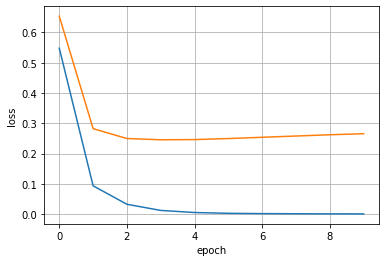

正解率： 0.934


In [16]:
pred = cnn.predict(X_test)
plt.plot(cnn.loss)
plt.plot(cnn.val_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.show()

print('正解率：', metrics.accuracy_score(y_test, pred))

## 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

$$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$$


N
o
u
t
 : 出力のサイズ（特徴量の数）


N
i
n
 : 入力のサイズ（特徴量の数）


P
 : ある方向へのパディングの数


F
 : フィルタのサイズ


S
 : ストライドのサイズ


h
 が高さ方向、 
w
 が幅方向である

### 【解答】

該当箇所
```
class Util:

    def get_output_shape(self):
        '''畳み込み後の形状'''
        output_img_shape = ((self.n_features + 2*self.n_padding - self.kernel_size) // self.strides + 1).astype(int)
        return output_img_shape
```

## 【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。

$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$

P
i
,
j
  : i行j列への出力する場合の入力配列のインデックスの集合。 
S
h
×
S
w
 の範囲内の行（p）と列（q）


S
h
,
S
w
 : 高さ方向（h）と幅方向（w）のストライドのサイズ


(
p
,
q
)
∈
P
i
,
j
 : 
P
i
,
j
 に含まれる行（p）と列（q）のインデックス


a
i
,
j
,
m
 : 出力される配列のi行j列、kチャンネルの値


x
p
,
q
,
k
 : 入力の配列のp行q列、kチャンネルの値


ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。


バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス 
(
p
,
q
)
 を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。

### 【解答】

該当箇所
```
class Pooling(metaclass=ABCMeta):
    def __init__(self, n_samples: int, pool: tuple, cnn):
        assert len(pool) == 2
        self.n_features = cnn.output_shape
        self.n_channels = cnn.n_channels
        self.n_samples = n_samples
        self.n_filters = cnn.n_filters
        self.pool_h = int(pool[0])
        self.pool_w = int(pool[1])
        self.pool = np.array(pool).astype(int)
        self.strides = np.array([1, 1]).astype(int)
        self.n_padding = np.array([0, 0]).astype(int)
        self.util = Util(self.n_channels, self.n_features, pool, self.n_padding, self.strides)
        self.output_shape = self.util.get_output_shape()
        
        self.x = None
        self.args = None


    @abstractmethod
    def p_forward(self):
        """
        値を抽出する処理
        
        return
        ----------------
        out : ndarray
          出力値
        args : ndarray
          
        """
        pass

    def forward(self, x):
        col = self.util.im2col(x)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        out, args = self.p_forward(x, col)
        self.x = x
        self.args = args
        return out


    def backward(self, dA):
        dA = dA.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dA.size, pool_size))
        dmax[np.arange(self.args.size), self.args.flatten()] = dA.flatten()
        dmax = dmax.reshape(dA.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = self.util.col2im(dcol)      
        return dx


class MaxPooling(Pooling):
    def p_forward(self, x, col):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.strides[0])
        out_w = int(1 + (W - self.pool_w) / self.strides[1])

        args = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        return out, args
```

## 【問題4】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。


範囲内の最大値ではなく、平均値を出力とするプーリング層です。


画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。

## 【問題5】平滑化
平滑化するためのFlattenクラスを作成してください。


フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。


この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。



### 【解答】

該当箇所
```
class Flatten:
    def __init__(self, FC):
        self.n_samples = FC.n_samples
        self.output_shape = (FC.n_samples, FC.n_filters, FC.output_shape[0], FC.output_shape[1])
        self.output_flat_shape = (FC.n_samples, FC.n_filters * FC.output_shape[0] * FC.output_shape[1])

    def __call__(self):
        return self.output_flat_shape

    def forward(self, data):
        self.n_samples = data.shape[0]
        flatten_data = data.reshape(self.n_samples, -1)
        return flatten_data

    def backward(self, data):
        return data.reshape(self.output_shape)
```

## 3.検証


## 【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。


精度は低くともまずは動くことを目指してください。

### 【解答】

以下の内容で実行
- 畳込み層（input_channel=1, kernel=1, filter=5, kernel_size=(3,3)）
- 活性化関数（ReLU）
- プーリング層（MaxPooling）
- 全結合層（出力node=400）
- 活性化関数（ReLU）
- 全結合層（出力node=200）
- 活性化関数（ReLU）
- 全結合層（出力node=10）
- 活性化関数（SoftMax）


In [22]:
cnn = ScratchDeepNeuralNetrowkClassifier(verbose=True, interval=1)
cnn.fit(X_train, y_train, X_val=X_test, y_val=y_test, sigma=0.01, lr=0.1, epoch=10, optimizer='AdaGrad')

[INFO] epoch : 1 / 10
       Loss(train): 0.5535639225517275
       Loss(test) : 0.6563501173714859
[INFO] epoch : 2 / 10
       Loss(train): 0.1348266227191559
       Loss(test) : 0.2451905107029283
[INFO] epoch : 3 / 10
       Loss(train): 0.07592407372102955
       Loss(test) : 0.20004426724132127
[INFO] epoch : 4 / 10
       Loss(train): 0.047570576215420546
       Loss(test) : 0.17374530531581342
[INFO] epoch : 5 / 10
       Loss(train): 0.03066832906632522
       Loss(test) : 0.15995402032986095
[INFO] epoch : 6 / 10
       Loss(train): 0.020165097414214957
       Loss(test) : 0.15389139187969827
[INFO] epoch : 7 / 10
       Loss(train): 0.01260114668144261
       Loss(test) : 0.14802125486651593
[INFO] epoch : 8 / 10
       Loss(train): 0.007947899961681762
       Loss(test) : 0.14716690309187205
[INFO] epoch : 9 / 10
       Loss(train): 0.0050100641902019296
       Loss(test) : 0.14711913571397686
[INFO] epoch : 10 / 10
       Loss(train): 0.0035566762996516337
       Loss(test

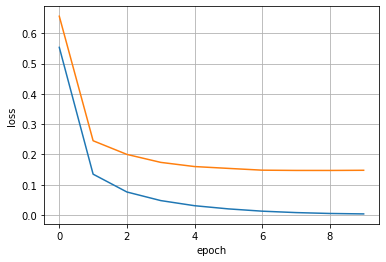

正解率： 0.9558


In [23]:
pred = cnn.predict(X_test)
plt.plot(cnn.loss)
plt.plot(cnn.val_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.show()

print('正解率：', metrics.accuracy_score(y_test, pred))

## 【問題7】（アドバンス課題）LeNet
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。現在では実用的に使われることはありませんが、歴史的に重要なのは1998年の LeNet です。この構造を再現してMNISTに対して動かし、Accuracyを計算してください。

<a href="http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf">
Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998.
</a>

<img src="../img/13-2.png"></img>

※上記論文から引用


サブサンプリングとは現在のプーリングに相当するものです。現代風に以下のように作ってみることにします。活性化関数も当時はシグモイド関数ですが、ReLUとします。


1.  畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
2. ReLU
3. 最大プーリング
4. 畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1
5. ReLU
6. 最大プーリング
7. 平滑化
8. 全結合層　出力ノード数120
9. ReLU
10. 全結合層　出力ノード数84
11. ReLU
12. 全結合層　出力ノード数10
13. ソフトマックス関数

In [19]:
class ScratchLeNet(ScratchDeepNeuralNetrowkClassifier):
   
    def fit(self, X, y, X_val=None, y_val=None, sigma=0.01, lr=0.01, epoch=3, optimizer='SGD'):
        # 引数をインスタンス変数へ
        self.sigma = sigma
        self.lr = lr
        self.epoch = epoch

        # 検証データの有無
        self.is_val = np.all(X_val != None) and np.all(y_val != None)

        # ミニバッチ
        batch_size = 20
        seed = 47

        # 形状・各層のノード数
        self.n_samples = X.shape[0]
        self.n_features = X.shape[-1]
        self.inputLayer_nodes = self.n_features
        self.fc1_nodes = 120
        self.fc2_nodes = 84
        self.out_nodes = 10
        self.optimizer = optimizer

        # CNN用
        self.n_channels = 1
        self.kernel_size = (5,5)
        self.n_filters = None
        self.n_strides = (1,1)
        self.CNN_input_shape = (self.n_channels, X.shape[-2], X.shape[-1])
        self.CNN_output_shape = None


        # 誤差格納用
        self.loss = []
        self.val_loss = []

        # yラベルデータをone-hotへ変換
        y = self._y_one_hot(y)
        if self.is_val:
            y_val = self._y_one_hot(y_val)

        # 最適化手法
        if self.optimizer == 'SGD':
            optimizer = SGD(self.lr)
        elif self.optimizer == 'AdaGrad':
            optimizer = AdaGrad(self.lr)


        # 各層・活性化関数のインスタンス生成
        '''1. 畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1'''
        self.CNN1 = Conv2d(input_shape = (1, 28, 28), 
                          initializer = HeInitializer(self.sigma, self.kernel_size[0], self.kernel_size[1]),
                          filters = 6,
                          kernel_size = self.kernel_size,
                          strides = self.n_strides,
                          padding = 'valid',
                          optimizer = optimizer)
        '''2. ReLU'''
        self.activationCNN1 = ReLU()
        '''3. 最大プーリング'''
        self.POO1 = MaxPooling(batch_size, (5,5), self.CNN1)
        poo1_out_h, poo1_out_w = self.POO1.output_shape

        '''4. 畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1'''
        self.CNN2 = Conv2d(input_shape = (6, poo1_out_h, poo1_out_w), 
                          initializer = HeInitializer(self.sigma, self.kernel_size[0], self.kernel_size[1]),
                          filters = 16,
                          kernel_size = self.kernel_size,
                          strides = self.n_strides,
                          padding = 'valid',
                          optimizer = optimizer)
        '''5. ReLU'''
        self.activationCNN2 = ReLU()
        '''6. 最大プーリング'''
        self.POO2 = MaxPooling(batch_size, (5,5), self.CNN2)
        '''7. 平滑化'''
        self.flatten = Flatten(self.POO2)
        self.flatten_out_shape = self.flatten.output_flat_shape[-1]

        '''8. 全結合層　出力ノード数120'''
        self.FC1 = FC(HeInitializer(self.sigma, self.flatten_out_shape, self.fc1_nodes), optimizer)
        '''9. ReLU'''
        self.activation1 = ReLU()
        '''10. 全結合層　出力ノード数84'''
        self.FC2 = FC(HeInitializer(self.sigma, self.fc1_nodes, self.fc2_nodes), optimizer)
        '''11. ReLU'''
        self.activation2 = ReLU()
        '''12. 全結合層　出力ノード数10'''
        self.OUT = FC(HeInitializer(self.sigma, self.fc2_nodes, self.out_nodes), optimizer)
        '''13. ソフトマックス関数'''
        self.activationOUT = Softmax()

        # ミニバッチ化
        getMiniBatch = GetMiniBatch(X, y, batch_size=batch_size, seed=seed)
        if self.is_val:
            val_batch_size = int(X_val.shape[0] / (self.n_samples/batch_size))
            getValMiniBatch = GetMiniBatch(X_val, y_val, batch_size=val_batch_size, seed=seed)
        else:
            getValMiniBatch = np.zeros([self.n_samples, 2])

        for epoch in range(self.epoch):
            for train, val in zip(getMiniBatch, getValMiniBatch):
                mini_X, mini_y = train
                mini_X_val, mini_y_val = val

                # フォワードプロパゲーション
                Z3 = self._forward_propagation(mini_X)
                # バックプロパゲーション
                self._back_propagation(mini_X, mini_y, Z3)

                if self.is_val:
                    # フォワードプロパゲーション
                    val_Z = self._forward_propagation(mini_X_val)
                    # 損失関数計算
                    self.activationOUT.cross_entropy_loss(val_Z, mini_y_val, self.is_val)

            # バッチ毎の損失の平均取得
            self._get_loss()

            # 学習過程表示
            if self.verbose and epoch % self.interval == 0:
                self._print_loss(epoch)


    def _forward_propagation(self, X):
        """
        フォワードプロパゲーション
        """
        X = self.activationCNN1.forward(self.CNN1.forward(X))
        X = self.POO1.forward(X)
        X = self.activationCNN2.forward(self.CNN2.forward(X))
        X = self.POO2.forward(X)
        X = self.flatten.forward(X)
        X = self.activation1.forward(self.FC1.forward(X))
        X = self.activation2.forward(self.FC2.forward(X))
        X = self.activationOUT.forward(self.OUT.forward(X))
        return X


    def _back_propagation(self, X, y, Z):
        """
        バックプロパゲーション
        """
        dZ = self.OUT.backward(self.activationOUT.backward(Z, y))
        dZ = self.FC2.backward(self.activation2.backward(dZ))
        dZ = self.FC1.backward(self.activation1.backward(dZ))
        dZ = self.flatten.backward(dZ)
        dZ = self.POO2.backward(dZ)
        dZ = self.CNN2.backward(self.activationCNN2.backward(dZ))
        dZ = self.POO1.backward(dZ)
        _ = self.CNN1.backward(self.activationCNN1.backward(dZ))



In [20]:
lenet = ScratchLeNet(verbose=True, interval=1)
lenet.fit(X_train, y_train, X_val=X_test, y_val=y_test, sigma=0.01, lr=0.1, epoch=10, optimizer='AdaGrad')

[INFO] epoch : 1 / 10
       Loss(train): 0.7072209359318198
       Loss(test) : 0.7695475357796712
[INFO] epoch : 2 / 10
       Loss(train): 0.16887436664765484
       Loss(test) : 0.2523510845050028
[INFO] epoch : 3 / 10
       Loss(train): 0.11412269937664683
       Loss(test) : 0.21456635122420847
[INFO] epoch : 4 / 10
       Loss(train): 0.08564489791529882
       Loss(test) : 0.19931514819686658
[INFO] epoch : 5 / 10
       Loss(train): 0.06678717495433598
       Loss(test) : 0.18768548825775933
[INFO] epoch : 6 / 10
       Loss(train): 0.0527118149360567
       Loss(test) : 0.17840456341863348
[INFO] epoch : 7 / 10
       Loss(train): 0.0423959971766656
       Loss(test) : 0.17360261696177753
[INFO] epoch : 8 / 10
       Loss(train): 0.035073649865925455
       Loss(test) : 0.1707941322271444
[INFO] epoch : 9 / 10
       Loss(train): 0.029340824208157257
       Loss(test) : 0.1687965882840013
[INFO] epoch : 10 / 10
       Loss(train): 0.024480443240217184
       Loss(test) : 0.1

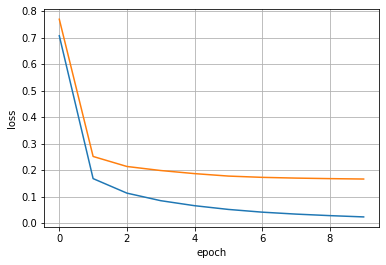

正解率： 0.9502


In [21]:
pred = lenet.predict(X_test)
plt.plot(lenet.loss)
plt.plot(lenet.val_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.show()

print('正解率：', metrics.accuracy_score(y_test, pred))

## 【問題8】（アドバンス課題）有名な画像認識モデルの調査
CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。


どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。


《参考》

<a href="https://keras.io/ja/applications/">
Applications - Keras Documentation
</a>

### 【解答】

<img src="../img/13-1.png"></img>

## 【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。


また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。


以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。



1. 

- 入力サイズ : 144×144, 3チャンネル
- フィルタサイズ : 3×3, 6チャンネル
- ストライド : 1
- パディング : なし

### 【1. 解答】
※自己学習用に求められている解答以外も記載しております。

- 入力 : (N, 3, 144, 144)
- im2col : ($N*Oh*Ow$, $C*Fh*Fw$) = ($N*142*142$, $3*3*3$)
- forward A : (N, 6, 142, 142)
- 平滑化 : (N, $6*142*142$) = (N, 120984)

→出力サイズ＝(N, 120984)、パラメータ数＝$3*3*3*6+6$＝168

2. 


- 入力サイズ : 60×60, 24チャンネル
- フィルタサイズ : 3×3, 48チャンネル
- ストライド　: 1
- パディング : なし



### 【2. 解答】

- 入力 : (N, 24, 60, 60)
- im2col : ($N*Oh*Ow$, $C*Fh*Fw$) = ($N*58*58$, $24*3*3$)
- forward A : (N, 48, 58, 58)
- 平滑化 : (N, $48*58*58$) = (N, 161472)

→出力サイズ＝(N, 161472)、パラメータ数＝$24*3*3*48+48$＝10416

3. 

- 入力サイズ : 20×20, 10チャンネル
- フィルタサイズ: 3×3, 20チャンネル
- ストライド : 2
- パディング : なし

＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。

### 【3. 解答】

- 入力 : (N, 10, 24, 24)
- im2col : ($N*Oh*Ow$, $C*Fh*Fw$) = ($N*9*9$, $10*3*3$)
- forward A : (N, 20, 9, 9)
- 平滑化 : (N, $20*9*9$) = (N, 1620)

→出力サイズ＝(N, 1620)、パラメータ数＝$10*3*3*20+20$＝1820

## 【問題10】（アドバンス課題）フィルタサイズに関する調査
畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。


- 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
- 高さや幅方向を持たない1×1のフィルタの効果

### 【解答】

- 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
  - 局所的な特徴を捉えにくいから？？
  - 加えて、パラメータの数が増加して計算コストが増すから？？
- 高さや幅方向を持たない1×1のフィルタの効果
  - 出力のチャンネル数(フィルタ数)を減らすことで次元削減ができるから？